## Business Understanding

This project aims to solve the problem of automatically classifying musical chords as either major or minor using audio input. Chord identification is a key task in music analysis, and automating it can save time on transcription and harmonic analysis. By using machine learning and music information retrieval (MIR) techniques, the goal is to create a tool that helps musicians, producers, and educators analyze music in real-time. The project focuses on making chord recognition more accessible and efficient, benefiting both students and professionals in the music industry.

---

## Tools/Methodologies

To handle the workflow, I'll use several Python libraries:

- [librosa](https://librosa.org/doc/latest/index.html) for extracting audio features, [numpy](https://numpy.org/doc/1.24/reference/index.html#reference) and [pandas](https://pandas.pydata.org/docs/reference/index.html#api) for data manipulation, and os and [Kaggle CLI](https://www.kaggle.com/code/donkeys/kaggle-python-api) to download the data directly into the notebook.
- [matplotlib](https://matplotlib.org/stable/api/index.html) and [seaborn](https://seaborn.pydata.org/api.html) for exploring and visualizing features like waveforms and spectrograms.
- [scikit-learn](https://scikit-learn.org/stable/api/index.html) for baseline models (e.g., logistic regression, SVM), and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) or [keras](https://keras.io/api/) for building CNNs.

In [54]:
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
import json
import os

# Audio feature extraction
import librosa

# for Kaggle CLI
from kaggle.api.kaggle_api_extended import KaggleApi

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models and utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Deep learning for CNNs
import tensorflow as tf
from tensorflow import keras

## Data Understanding
The dataset used in this project is sourced from the [Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification) dataset on Kaggle. It contains audio files `.wav` format of chords played on two instruments: guitar and piano. The raw data has been scraped from various sources and is already available for download on Kaggle, eliminating the need for manual data collection. The dataset is well-suited for this project, as it provides a clear distinction between major and minor chords, which is the focus of the classification task.

The features for the model will be extracted from the audio files using techniques such as Mel-frequency cepstral coefficients (MFCCs) or spectrograms, which capture important frequency and temporal information from the audio signals. Although other individuals may have used this dataset for similar chord classification tasks, this project will build upon existing work by focusing specifically on distinguishing between major and minor chords, potentially improving upon current models or exploring new machine learning techniques for this type of classification.

In [55]:
# uncomment if replicating project
# !pip install kaggle

In [56]:
# Load kaggle.json credentials
api_config_path = os.path.join(os.getcwd(), 'kaggle.json')
with open(api_config_path, 'r') as f:
    kaggle_config = json.load(f)

# Set environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Ensure the 'dataset' folder exists
dataset_dir = os.path.join(os.getcwd(), 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

# Use the Kaggle API to download the dataset
api.dataset_download_files('deepcontractor/musical-instrument-chord-classification',
                           path=dataset_dir, unzip=True)

print("Dataset downloaded and extracted to:", dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
Dataset downloaded and extracted to: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset


In [81]:
# Define the base directory where the audio files are stored
base_dir = os.path.join(os.getcwd(), 'dataset', 'Audio_Files')

# Prepare to collect file details
file_details = []

# Loop through each category directory ('Major' and 'Minor')
for category in ['Major', 'Minor']:
    category_dir = os.path.join(base_dir, category)
    
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            # Full path to file
            file_path = os.path.join(category_dir, filename)
            # Append the file path, filename (used as ID), and label to the list
            file_details.append({'path': file_path, 'id': filename, 'label': category})

# Save collected file details as a DataFrame
file_data = pd.DataFrame(file_details)

file_data.head()

,path,id,label
0,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_0.wav,Major
1,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_1.wav,Major
2,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_10.wav,Major
3,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_100.wav,Major
4,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_101.wav,Major


---

## Data Preparation

The dataset consists of raw .wav files, so no traditional tabular data is available. Preprocessing will involve extracting features like MFCCs, spectrograms, or chroma features to transform the audio into usable data. Challenges include ensuring that these features correctly capture the harmonic information while handling variations in recording quality and instrument type. We estimate several hundred rows of data, each representing an individual chord sample. Visualizations like waveform plots and spectrograms will be used to explore the features that distinguish major from minor chords.

#### Extract Feature Function
- **Audio Loading** with a specified sampling rate (sr)
- **Chroma Features**: calculated using the short-time Fourier transform (STFT) of the audio file. Chroma features capture the essence of the pitch content within each octave group - which is vital for chord identification.
- **MFCCs**: used to capture the timbral aspects of an audio signal. (This is what makes a song or chord 'feel' a certain way!) The first few coefficients especially provide a good representation of the overall spectral shape which is influenced by the harmonic structure of the chord.
- **Feature Averaging**: for both Chroma Features and MFCCs - features are averaged over the time frames to reduce them to a single vector per audio file.
- **Error Handling**: for issues with processing the audio file - especially important for our final deployment.

#### Encode Labels
Our target feature 'label' should be converted into a numerical format.
> 0: Major 
> 1: Minor

In [82]:
def extract_chord_features(file_path, sr=22050, hop_length=512, n_fft=2048):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=hop_length).mean()

        # Return a dictionary of features
        return {
            'chroma': chroma,
            'mfcc': mfccs,
            'spectral_centroid': spectral_centroid,
            'zero_crossing_rate': zero_crossing_rate
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [83]:
features_data = []

# Extracting features for each file and storing them in the list
for index, row in file_data.iterrows():
    features = extract_chord_features(row['path'])
    if features is not None:
        # Flatten the feature dicts for DataFrame construction
        feature_dict = {f'chroma_{i}': features['chroma'][i] for i in range(len(features['chroma']))}
        feature_dict.update({f'mfcc_{i}': features['mfcc'][i] for i in range(len(features['mfcc']))})
        feature_dict['spectral_centroid'] = features['spectral_centroid']
        feature_dict['zero_crossing_rate'] = features['zero_crossing_rate']
        feature_dict['id'] = row['id'].replace('.wav', '')
        feature_dict['Label'] = row['label']
        features_data.append(feature_dict)

# Creating the DataFrame
data_features = pd.DataFrame(features_data)

# Display the first few rows of the DataFrame to ensure it is correct
print(data_features.head())

   chroma_0  chroma_1  chroma_2  chroma_3  chroma_4  chroma_5  chroma_6  \
0  0.742913  0.204407  0.173953  0.280547  0.802854  0.172853  0.121578   
1  0.729958  0.307365  0.092075  0.152823  0.467690  0.221199  0.145914   
2  0.383773  0.197410  0.057362  0.069614  0.227125  0.297883  0.736757   
3  0.223433  0.931608  0.578779  0.638870  0.234647  0.322008  0.154993   
4  0.137541  0.349761  0.289738  0.445542  0.294066  0.478135  0.327209   

   chroma_7  chroma_8  chroma_9  ...    mfcc_14    mfcc_15    mfcc_16  \
0  0.434359  0.100009  0.015909  ...  -9.903286 -18.900269 -12.511242   
1  0.392128  0.212576  0.046519  ...  -3.354305  -3.365277  -7.338716   
2  0.224346  0.028015  0.237962  ... -21.908617 -10.495011  -6.881425   
3  0.370598  0.350831  0.110103  ... -10.768335 -18.064676 -18.102715   
4  0.586636  0.273700  0.086248  ...  -6.416312  -7.856865  -4.621236   

     mfcc_17    mfcc_18   mfcc_19  spectral_centroid  zero_crossing_rate  \
0 -15.546177 -21.641695 -6.917932 

In [60]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
data_features['Label'] = label_encoder.fit_transform(data_features['Label'])

---

# Modeling

This is a classification problem, with the goal of predicting whether a chord is major or minor. The initial plan is to use a basic model like logistic regression or SVM as a baseline. After extracting features like MFCCs or spectrograms, we will establish the baseline and then experiment with more advanced models like convolutional neural networks (CNNs) to improve accuracy.

In [61]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout

In [62]:
# Split data into features and target
X = data_features.drop(['id', 'Label'], axis=1)
y = data_features['Label']

# Splitting the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [63]:
# Model configuration
input_shape = (X_train.shape[1], 1)

# Building the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
# Reshape for CNN - need 3D arrays (samples, time steps, features)
# TODO: should try just extracting these features rather than reshaping 1D to 3D

X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.values.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

In [65]:
# Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
22/22 [==============================] - 1s 7ms/step - loss: 5.6127 - accuracy: 0.5167 - val_loss: 1.5401 - val_accuracy: 0.6047
Epoch 2/20
22/22 [==============================] - 0s 4ms/step - loss: 1.0105 - accuracy: 0.5531 - val_loss: 0.6954 - val_accuracy: 0.6047
Epoch 3/20
22/22 [==============================] - 0s 3ms/step - loss: 0.6953 - accuracy: 0.5619 - val_loss: 0.6742 - val_accuracy: 0.6047
Epoch 4/20
22/22 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5822 - val_loss: 0.6805 - val_accuracy: 0.6047
Epoch 5/20
22/22 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.5866 - val_loss: 0.6792 - val_accuracy: 0.6047
Epoch 6/20
22/22 [==============================] - 0s 3ms/step - loss: 0.6875 - accuracy: 0.5837 - val_loss: 0.6810 - val_accuracy: 0.6047
Epoch 7/20
22/22 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5895 - val_loss: 0.6782 - val_accuracy: 0.6047
Epoch 8/20
22/22 [==

---

# Evaluation

To evaluate the model, we will use metrics such as accuracy, precision, recall, and F1-score, focusing on correctly classifying both major and minor chords. The minimum viable product (MVP) will involve building a baseline model (e.g., logistic regression or SVM) to classify the chords with reasonable accuracy. Stretch goals include improving the model using more complex techniques like CNNs or RNNs, and addressing any data imbalances to achieve better generalization and robustness.

In [66]:
from sklearn.metrics import classification_report

In [67]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

3/3 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.5349
Test Accuracy: 53.49%


In [68]:
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, zero_division=0))

              precision    recall  f1-score   support

       Major       0.53      1.00      0.70        46
       Minor       0.00      0.00      0.00        40

    accuracy                           0.53        86
   macro avg       0.27      0.50      0.35        86
weighted avg       0.29      0.53      0.37        86



### Model Iterations:

#### Model v1:

Classification Report: (CNN model - 1D arrays reshaped to 3D):

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| Major | 0.53      | 1.00   | 0.70     | 46      |
| Minor | 0.00      | 0.00   | 0.00     | 40      |
| **accuracy** | | | 0.53 | 86 |
| **macro avg** | 0.27 | 0.50 | 0.35 | 86 |
| **weighted avg** | 0.29 | 0.53 | 0.37 | 86 |

This is alarming - our scores for precision, recall, and f1-score for the Minor class are ALL zero. 
This is probably because we are focusing in on timbral aspects of the audio, rather than the individual frequencies of the notes in the chords. 


#### Model v2:

Classification Report: ()

## Music and Math

Each musical note corresponds to a fundamental frequency - the lowest frequency of a note that is musically pleasing. This frequency is what characterizes the note, which is represented by letters ['A', 'B', 'C', 'D', 'E', 'F', 'G']. 

#### Frequency:

The frequency \( f \) of a note can be calculated with the following formula:

$$ f = f_0 \times 2^{\frac{n}{12}} $$

Where:
- `f_0` is the frequency of a reference note (usually the note **A4**, which is **440 Hz**).
- `n` is the number of half-steps away from the reference note. Positive values of `n` indicate higher notes, while negative values indicate lower notes.

#### Chords and Harmonics:

A chord is a combination of several notes played simultaneously, which creates a harmonious sound. The frequencies of the notes in a chord are related harmonically. For example, a simple major chord consists of the root note, a major third above the root, and a perfect fifth above the root.

In order to determine if a chord is Major or Minor - we will need to analyze the frequencies and how they're related, aka the harmonics!

In [105]:
from IPython.display import Audio

# To visualize audio data
from scipy.fft import fft
from scipy.io import wavfile

In [101]:
def play_audio(file_id, df=file_data):
    # Extract the row from the dataframe using the provided index
    row = df.iloc[file_id]
    # Retrieve the path to the audio file from the row
    filename = row['path']
    # Create and return an Audio object to play the audio
    return Audio(filename)

In [102]:
file_id = 440 #up to 858

# Use the play_audio function to play the audio
audio_player = play_audio(file_id)

audio_player

In [110]:
def plot_audio(file_id, df=file_data, max_freq=2500):
    # Extract the row from the DataFrame using the provided index
    row = df.iloc[file_id]
    # Retrieve the path to the audio file from the row
    filename = row['path']
    
    # Read audio file
    samplerate, data = wavfile.read(filename)
    times = np.arange(len(data)) / float(samplerate)
    
    # Plot time domain
    plt.figure(figsize=(16, 6))  # Increased figure size for better visibility
    plt.subplot(1, 2, 1)
    plt.title("Time Domain")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.plot(times, data)
    
    # Plot frequency domain
    fft_data = fft(data)
    freqs = np.fft.fftfreq(len(fft_data), 1/samplerate)
    magnitude = np.abs(fft_data)[:len(data)//2]
    freqs = freqs[:len(data)//2]
    
    plt.subplot(1, 2, 2)
    plt.title("Frequency Domain")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    if max_freq is not None:
        # Limit the x-axis to max_freq if specified
        plt.xlim([0, max_freq])
    plt.plot(freqs, magnitude)
    plt.show()

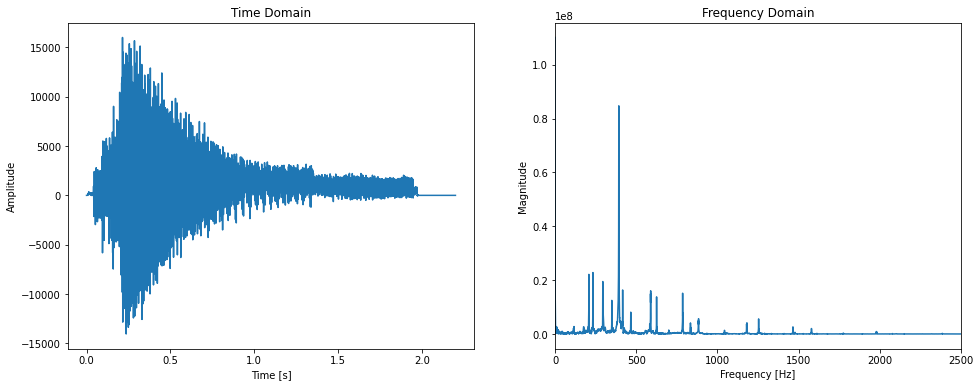

In [111]:
plot_audio(file_id)

---

# Deployment

The results will be delivered through a simple Streamlit web app, where users can upload or record audio files to classify as major or minor chords. The app will provide real-time feedback, displaying the classification result along with confidence scores and visualizations such as waveforms or spectrograms. The app will be hosted on Streamlit Cloud, making it easily accessible and user-friendly for quick chord analysis.